In [1]:
import numpy as np
# 假设有 3 台机器和 3 个操作
m = 4 # 机器数量
N = 2 # 表示机器的二进制 (0, 1)
n = 2 # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3, 4],[4 ,2, 3, 1]])

b = np.array([[0, 0],[1, 0] ,[0, 1],[1,1]])
# 非法数组(用于表示机器数)(1, 1)
bw = np.array([])
# 常数
K1 = 100
P = 30
# print(len(bw))
# 量子比特数量
num_qubits = n * N + l

In [2]:
def append_multi_rzz_term(qc, qubits, gamma): 
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    if len(qubits)==1:
        qc.rz(gamma, qubits[0])
    else:
        control_qubits = qubits[:N-1]
       
        target_qubit = qubits[N-1:]
       
        n_controls = len(control_qubits)
        if n_controls == 1:     
            qc.cx(control_qubits[0],target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])
        qc.rz(gamma, target_qubit[0])
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])

In [3]:
def append__zz_term( qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)

def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)
def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [4]:
def get_cost_circuit1(gamma, qc):
    for h in range(l):
        coef = - 2**h
        append__z_term(qc, N * n + h, coef * gamma)
    return qc

\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [5]:
import itertools
def get_cost_circuit2(gamma, qc):
    # print(len(bw))
    if len(bw) == 0:
        return qc
    for j in range(len(bw)):
        for i in range(n):
            constant1 = (1 / 4)*(1 - 2 * bw[j, 0])
            append__z_term(qc, i * N, constant1 * gamma)# 系数 1/2^N
            constant2 = (1 / 4)*(1 - 2 * bw[j, 1])
            append__z_term(qc, i * N + 1, constant2 * gamma)# 系数
            constant3 = (1 / 4)*(1 - 2 * bw[j, 0])*(1 - 2 * bw[j, 1])
            append__zz_term(qc, i * N, i * N + 1, constant3 * gamma)           
    return qc

\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [6]:
def get_cost_circuit3(gamma, qc):
    for j in range(m):
        # 12
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[0, j]
        append__zz_term(qc, 0, 1, P * 2 * constant * gamma)
        # 14
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 0]) * p[0, j] * p[1, j]
        append__zz_term(qc, 0, 2, P * 2 * constant * gamma)
        # 15
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append__zz_term(qc, 0, 3, P * 2 * constant * gamma)
        # 24
        constant = (1/16)*(1-2*b[j, 1])*(1-2*b[j, 0]) * p[0, j] * p[1, j]
        append__zz_term(qc, 1, 2, P * 2 * constant * gamma)
        # 25
        constant = (1/16)*(1-2*b[j, 1])*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append__zz_term(qc, 1, 3, P * 2 * constant * gamma)
        # 45
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[1, j] * p[1, j]
        append__zz_term(qc, 2, 3, P * 2 * constant * gamma)
        # 13
        qubits_index = np.array([1])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 16
        qubits_index = np.array([0,2,3])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 23
        qubits_index = np.array([0])
        constant = (1/16)*(1-2*b[j, 1])*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 26
        qubits_index = np.array([1,2,3])
        constant = (1/16)*(1-2*b[j, 1])*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 34
        qubits_index = np.array([0,1,2])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1])*(1-2*b[j, 0]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 35
        qubits_index = np.array([0,1,3])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1])*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 36
        qubits_index = np.array([0,1,2,3])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 0])*(1-2*b[j, 1])*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 46
        qubits_index = np.array([3])
        constant= (1/16)*(1-2*b[j, 0])*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[1, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 56
        qubits_index = np.array([2])
        constant = (1/16)*(1-2*b[j, 1])*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[1, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 01
        qubits_index = np.array([0])
        constant = (1/16)*(1-2*b[j, 0]) * p[0, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 02
        qubits_index = np.array([1])
        constant = (1/16)*(1-2*b[j, 1]) * p[0, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 03
        qubits_index = np.array([0,1])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 04
        qubits_index = np.array([2])
        constant = (1/16)*(1-2*b[j, 0]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 05
        qubits_index = np.array([3])
        constant = (1/16)*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 06
        qubits_index = np.array([2,3])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[0, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 71
        qubits_index = np.array([0])
        constant = (1/16)*(1-2*b[j, 0]) * p[1, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 72
        qubits_index = np.array([1])
        constant = (1/16)*(1-2*b[j, 1]) * p[1, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 73
        qubits_index = np.array([0,1])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[1, j] * p[0, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 74
        qubits_index = np.array([2])
        constant = (1/16)*(1-2*b[j, 0]) * p[1, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 75
        qubits_index = np.array([3])
        constant = (1/16)*(1-2*b[j, 1]) * p[1, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        # 76
        qubits_index = np.array([2,3])
        constant = (1/16)*(1-2*b[j, 0])*(1-2*b[j, 1]) * p[1, j] * p[1, j]
        append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
        
        
        for i in range(n):  # 遍历 i 的范围
            qubits_index = np.array([i * N])
            constant = (1/8)*(1-2*b[j, 0]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([i * N+1])
            constant = (1/8)*(1-2*b[j, 1]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([i * N, i * N + 1])
            constant = (1/8)*(1-2*b[j, 0]) * (1-2*b[j, 1]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([4])
            constant = (-1/8) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([i * N+1])
            constant = (1/8)*(1-2*b[j, 1]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([i * N, i * N + 1])
            constant = (1/8)*(1-2*b[j, 0]) * (1-2*b[j, 1]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([i * N,4])
            constant = (-1/8)*(1-2*b[j, 0]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([i * N+1,4])
            constant = (-1/8)*(1-2*b[j, 1]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
            qubits_index = np.array([i * N, i * N + 1, 4])
            constant = (-1/8)*(1-2*b[j, 0]) * (1-2*b[j, 1]) * p[i, j]
            append_multi_rzz_term(qc, qubits_index, P * 2 * constant * gamma)
            
        for h1 in range(l):  # 遍历 h 的范围
            for h2 in range(l):  # 遍历 h' 的范围
                coef = 2 ** (h1 - 1) * 2 ** (h2 - 1)  # 计算系数权重

                # -Z_h1 项
                append__z_term(qc, n * N + h1, 2 * P * coef * gamma)

                # -Z_h2 项
                append__z_term(qc, n * N + h2, 2 * P * coef * gamma)

                # Z_h1 Z_h2 项
                if h1 != h2:  # 避免重复
                    append__zz_term(qc, n * N + h1, n * N + h2, 2 * P * coef * gamma)
                

In [7]:
def get_mixer_circuit(beta, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc

In [8]:
def invert_counts(s):
    return s[::-1]

In [9]:
from qiskit import Aer, QuantumCircuit, execute
# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params)//2], params[len(params)//2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    # print(qc)

    length  = len(params)
    for i in range(int(length/2)):

        get_cost_circuit1(gamma[i], qc)
        get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n*N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n*N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range (n):
                constant = 1
                for k in range (N):
                    constant = constant*(1-(s_ik[i,k]-bw[j,k])**2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2*(1-(s_ik[i,k]-b[j,k])**2)
                constant1 += p[i,j]*constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            constant = max(0, constant1 - constant3)
            E3 += P * (constant)**2
        
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        
        E =  E1 + E2 + E3
        
        expectation += E * prob

    return expectation, counts

In [10]:
from qiskit_algorithms.optimizers import COBYLA

# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    optimizer = COBYLA(rhobeg = 1.5, tol = 1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [11]:
import time

# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(100):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0,  2 * np.pi)
        if k >0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        result = optimize_qaoa(init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 1 层   第 30 个参数
第： 1 层   第 31 个参数
第： 1 层   第 32 个参数
第： 1 层   第 33 个参数
第： 1 层   第 34 个参数
第： 1 层   第 35 个参数
第： 1 层   第 36 个参数
第： 1 层   第 37 个参数
第： 1 层   第 38 个参数
第： 1 层   第 39 个参数
第： 1 层   第 40 个参数
第： 1 层   第 41 个参数
第： 1 层   第 42 个参数
第： 1 层   第 43 个参数
第： 1 层   第 44 个参数
第： 1 层   第 45 个参数
第： 1 层   第 46 个参数
第： 1 层   第 47 个参数
第： 1 层   第 48 个参数
第： 1 层   第 49 个参数
第： 1 层   第 50 个参数
第： 1 层   第 51 个参数
第： 1 层   第 52 个参数
第： 1 层   第 53 个参数
第： 1 层   第 54 个参数
第： 1 层   第 55 个参数
第：

优化时间： 3185.332243680954
Optimal parameters: [7.02324182 0.68437228 0.22618104 6.70028759 0.83234342 1.6675969 ]
Optimal value: 23.283499999999997
Final expectation value: 23.283499999999997
Final measurement counts: {'00111': 6154, '10111': 2744, '00101': 584, '10101': 137, '00110': 111, '11111': 99, '10110': 70, '01111': 26, '00100': 16, '01101': 15, '11101': 11, '00011': 9, '10100': 7, '01110': 4, '01100': 4, '10011': 3, '11011': 3, '11110': 1, '00010': 1, '11100': 1}


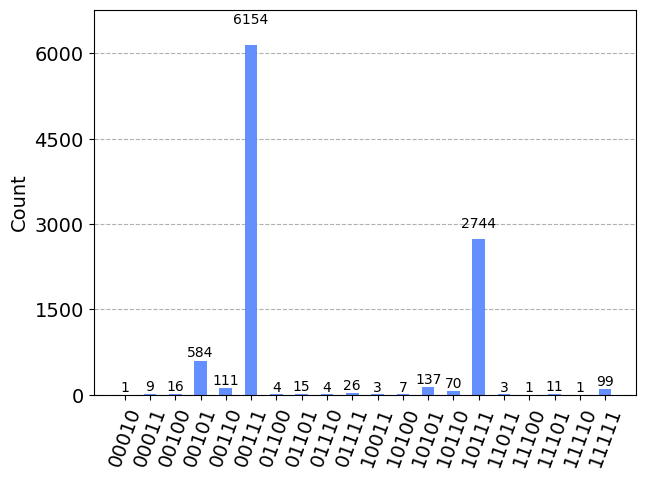

In [12]:
from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)

In [13]:
expectation = 0
bitstring = "00011"
z_h = np.array([int(bit) for bit in bitstring[(n*N):]])
s_ik = np.array([int(bit) for bit in bitstring[:(n*N)]]).reshape(n, N)
E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = 0
for j in range(len(bw)):
    for i in range (n):
        constant = 1
        for k in range (N):
            constant = constant*(1-(s_ik[i,k]-bw[j,k])**2)
        E2 += constant
E2 = K1 * E2
E3 = 0
for j in range(m):
    constant1 = 0
    # print("机器：", j)
    for i in range(n):
        constant2 = 1
        for k in range(N):
            constant2 = constant2*(1-(s_ik[i,k]-b[j,k])**2)
        # print("constant2:", constant2)
        # print("p[i,j]:", p[i,j])
        constant1 += p[i,j]*constant2
    # print("constant1:", constant1)
    constant3 = 0
    for h in range(l):
        constant3 += 2 ** h * z_h[h]
    # print("constant3:", constant3)
    constant = max(0, constant1 - constant3)
    E3 += (constant)**2
        
        # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])
        
E =  E1 + K1 * E2 + P * E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

1
0
4
